In [18]:
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
import json
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer
import arviz as az

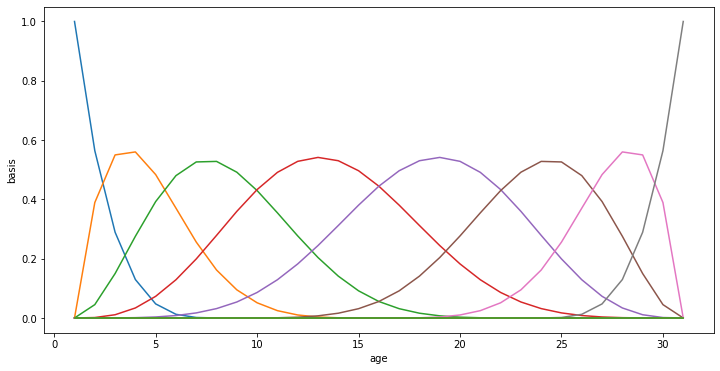

In [2]:
# knot 수에 따라 Bspline 파일 변

degree = 4
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [3]:
transformer = PowerTransformer()
y_data_raw = pd.read_csv("../data/y_count_original.csv")
y_data_raw.drop(columns="age", inplace=True)
transformer.fit(y_data_raw.values[~np.isnan(y_data_raw)].reshape(-1, 1))

PowerTransformer()

In [4]:
y_data = pd.read_csv(os.path.realpath("../data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("../data/x_age.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("../data/ship_index.csv"), usecols=["ship"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("../data/engine_index.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
shipsize_data = pd.DataFrame({"shipsize": np.zeros(y_data.shape[0], dtype=np.int32)})
ship_size_mapping_data = pd.read_csv(os.path.realpath("../data/shipsize_index.csv"), usecols=["shipsize"])
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]
    shipsize_data.at[x, "shipsize"] = ship_size_mapping_data.at[ship_data.at[x, "ship"]-1, "shipsize"]


In [5]:
engine_count = int(np.max(engine_data["engine"]))
ship_count = int(np.max(ship_data["ship"]))
max_age = int(np.max(age_data["age"]))
data_count = y_data.shape[0]
shipsize_count = int(np.max(shipsize_data["shipsize"]))
print(engine_count, shipsize_count, ship_count, max_age, data_count)
print(engine_data.shape, shipsize_data.shape, ship_data.shape, age_data.shape, y_data.shape)

5 5 99 31 653
(653, 1) (653, 1) (653, 1) (653, 1) (653, 1)


# Model 1. Use engine type for data "engine"

In [6]:
model_file = os.path.join('./models','layer3_nc_diffsd_parammubar.stan')
engine_model = CmdStanModel(stan_file=model_file) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/models/layer3_nc_diffsd_parammubar


In [7]:
engine_model_data = {
    "K" : basis_df.shape[1],
    "N" : data_count,  # number of total values
    "T" : max_age,  # length of time of data(31)
    "S" : ship_count, #failure_df.shape[1],  # number of ships(99)
    "E" : engine_count,  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": data_count,
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [8]:
%%time
engine_model_fit = engine_model.sample(chains=4, cores=4, data=engine_model_data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


CPU times: user 553 ms, sys: 49 ms, total: 602 ms
Wall time: 2min 23s


In [9]:
engine_model_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpzqqoy3fu/layer3_nc_diffsd_parammubar-202008242026-1-8l43c30f.csv, /tmp/tmpzqqoy3fu/layer3_nc_diffsd_parammubar-202008242026-2-6udz_wlu.csv, /tmp/tmpzqqoy3fu/layer3_nc_diffsd_parammubar-202008242026-3-o7chpoe6.csv, /tmp/tmpzqqoy3fu/layer3_nc_diffsd_parammubar-202008242026-4-eohyu_si.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
32 of 4000 (0.8%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


"Processing csv files: /tmp/tmpzqqoy3fu/layer3_nc_diffsd_parammubar-202008242026-1-8l43c30f.csv, /tmp/tmpzqqoy3fu/layer3_nc_diffsd_parammubar-202008242026-2-6udz_wlu.csv, /tmp/tmpzqqoy3fu/layer3_nc_diffsd_parammubar-202008242026-3-o7chpoe6.csv, /tmp/tmpzqqoy3fu/layer3_nc_diffsd_parammubar-202008242026-4-eohyu_si.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n32 of 4000 (0.8%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete."

In [10]:
#pd.set_option('display.max_rows', None)
engine_model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-414.284000,0.493943,17.491100,-443.273000,-413.681000,-386.325000,1253.95,4.88212,1.001250
mu_a_bar,-0.050469,0.013881,0.845801,-1.422880,-0.054290,1.340390,3712.93,14.45600,0.999393
mu_w_bar[1],-1.132920,0.009701,0.488496,-1.945550,-1.130030,-0.334771,2535.51,9.87178,0.999668
mu_w_bar[2],0.818744,0.010423,0.521435,-0.052646,0.821920,1.675630,2502.64,9.74380,0.999731
mu_w_bar[3],0.317162,0.011118,0.616286,-0.697464,0.327856,1.305250,3072.34,11.96190,0.999857
...,...,...,...,...,...,...,...,...,...
y_new_pred[649],2.148610,0.012977,0.818438,0.786406,2.150600,3.505950,3977.76,15.48700,1.000400
y_new_pred[650],0.497177,0.013865,0.870007,-0.940673,0.502238,1.922220,3937.47,15.33020,1.000810
y_new_pred[651],0.699936,0.013275,0.868509,-0.746428,0.696622,2.140290,4280.64,16.66630,1.000140


In [11]:
pd.reset_option('display.max_rows')

In [28]:
engine_yhat = np.mean(engine_model_fit.get_drawset(params=["y_new_pred"]), axis=0).values
engine_yhat.shape

(653,)

In [29]:
mean_squared_error(engine_yhat, y_data["y"].values)

0.48830362801787747

In [30]:
smape(engine_yhat, y_data["y"].values)

1.0733717285320659

# Model 2. Use shipsize instead of engine

In [15]:
shipsize_model = CmdStanModel(stan_file=model_file) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/models/layer3_nc_diffsd_parammubar


In [16]:
shipsize_model_data = {
    "K" : basis_df.shape[1],
    "N" : data_count,  # number of total values
    "T" : max_age,  # length of time of data(31)
    "S" : ship_count, # number of ship types(99)
    "E" : shipsize_count,  # number of unique SHIPS
    "age": age_data["age"].values.tolist(),
    "engine": ship_size_mapping_data["shipsize"].values.tolist(),  # ship size mapping
    "ship": ship_data["ship"].values.tolist(),  # ship type mapping
    "Y": y_data["y"].values.tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": data_count,
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [17]:
%%time
shipsize_model_fit = shipsize_model.sample(chains=4, cores=4, data=shipsize_model_data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


CPU times: user 552 ms, sys: 53 ms, total: 605 ms
Wall time: 2min 28s


In [31]:
shipsize_yhat = np.mean(shipsize_model_fit.get_drawset(params=["y_new_pred"]), axis=0).values
shipsize_yhat.shape

(653,)

In [33]:
mean_squared_error(shipsize_yhat, y_data["y"].values)

0.48888782741055203

In [34]:
smape(shipsize_yhat, y_data["y"].values)

1.0740230375499176

## check out arviz stuf

In [23]:
engine_az_inference = az.from_cmdstanpy(engine_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

In [24]:
shipsize_az_inference = az.from_cmdstanpy(shipsize_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

In [25]:
az.loo(engine_az_inference, pointwise=True)

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 653 log-likelihood matrix

         Estimate       SE
elpd_loo  -801.93    18.74
p_loo       94.76        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      630   96.5%
 (0.5, 0.7]   (ok)         16    2.5%
   (0.7, 1]   (bad)         7    1.1%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [26]:
az.loo(shipsize_az_inference, pointwise=True)

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 653 log-likelihood matrix

         Estimate       SE
elpd_loo  -802.49    18.80
p_loo       95.38        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      630   96.5%
 (0.5, 0.7]   (ok)         18    2.8%
   (0.7, 1]   (bad)         5    0.8%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [27]:
comp = az.compare({"engine": engine_az_inference, "shipsize": shipsize_az_inference}, ic="loo")
comp

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
engine,0,-801.927,94.7641,0,0.627881,18.9463,0,True,log
shipsize,1,-802.488,95.3773,0.561234,0.372119,19.0045,0.450239,True,log


In [35]:
stacked_yhat = np.dot(np.transpose(np.vstack([engine_yhat, shipsize_yhat])), comp.weight.values)

In [36]:
mean_squared_error(stacked_yhat, y_data["y"].values)

0.4884433942609769

In [37]:
smape(stacked_yhat, y_data["y"].values)

1.0738686170605993

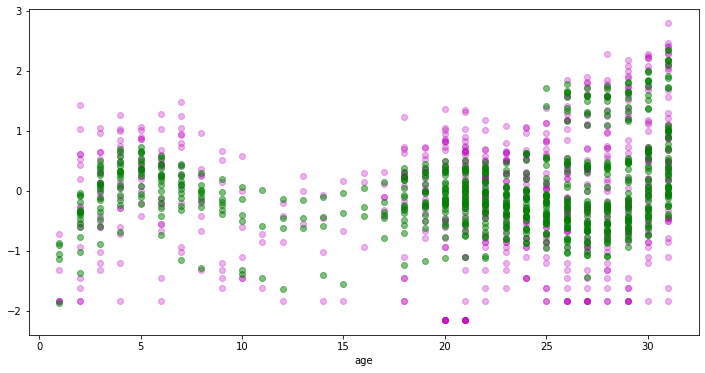

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
ax.scatter(age_data, stacked_yhat, color="green", linewidth=1, alpha=0.5)